In [ ]:
!python --version

Python 3.11.13


# **0. Installer les librairies**

In [2]:
!pip install osmnx folium networkx geopandas pandas shapely
import folium
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString

# **1. Prétraitements des données (échelle1et2)**

In [ ]:
# Charger la couche de segments
segments = gpd.read_file("segments_distanceaucentre_manu_2154.shp")

# Reprojeter en WGS84 pour extraire les lat/lon
segments = segments.to_crs("EPSG:4326")

# Préparer les colonnes
data = []
for idx, row in segments.iterrows():
    line = row.geometry
    if line is not None and line.geom_type == 'LineString':
        start = line.coords[0]
        end = line.coords[-1]
        data.append({
            "from_stop_name": f"stop_{idx}_A",
            "to_stop_name": f"stop_{idx}_B",
            "route_type": "manu",
            "from_lat": start[1],
            "from_lon": start[0],
            "to_lat": end[1],
            "to_lon": end[0],
            "tram_min": None,
            "pieds_min": None,
            "velo_min": None,
            "voiture_min": None
        })

# Convertir en DataFrame
df = pd.DataFrame(data)

# Afficher les 5 premières lignes
print(df.head())


  from_stop_name to_stop_name route_type   from_lat  from_lon     to_lat  \
0       stop_0_A     stop_0_B       manu  48.581910  7.751036  48.584706   
1       stop_1_A     stop_1_B       manu  48.592550  7.774836  48.596134   
2       stop_2_A     stop_2_B       manu  48.581444  7.742169  48.583377   
3       stop_3_A     stop_3_B       manu  48.572931  7.745115  48.574824   
4       stop_4_A     stop_4_B       manu  48.575231  7.740418  48.578129   

     to_lon tram_min pieds_min velo_min voiture_min  
0  7.749228     None      None     None        None  
1  7.774592     None      None     None        None  
2  7.740221     None      None     None        None  
3  7.753589     None      None     None        None  
4  7.734287     None      None     None        None  


In [ ]:
print(f"Nombre de segments : {segments.shape[0]}")

Nombre de segments : 178


In [ ]:
# --- Export final ---
df.to_csv('segments_coordonnees.csv', index=False, encoding='utf-8-sig')
print("✅ Fichier enregistré : segments_coordonnees.csv")

✅ Fichier enregistré : segments_coordonnees.csv


# **2. ORS : Calculer le temps des trajets (échelle1et2)**

In [3]:
!pip install openrouteservice
import openrouteservice
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("segments_coordonnees.csv")

# === Paramètres ===
ORS_API_KEY = "5b3ce3597851110001cf6248000fc647f85c43309e7b2f6f9c68bfc0" # à personnaliser
MAX_SIZE = 59  # max 59x59 = 3481
PROFILES = ['foot-walking', 'cycling-regular', 'driving-car']

# === ORS client ===
client = openrouteservice.Client(key=ORS_API_KEY)

# Construire la table des arrêts uniques (stop_name + coords)
# Concaténer tous les points de départ et d'arrivée
coord_df = pd.DataFrame({
    'stop_name': df['from_stop_name'].tolist() + df['to_stop_name'].tolist(),
    'lat': df['from_lat'].tolist() + df['to_lat'].tolist(),
    'lon': df['from_lon'].tolist() + df['to_lon'].tolist()
}).drop_duplicates().dropna().reset_index(drop=True)

# Préparer les coordonnées au format ORS (lon, lat)
coords = list(zip(coord_df['lon'], coord_df['lat']))


# === Fonction de découpage en blocs ORS-safe ===
def split_blocks(data, size):
    for i in range(0, len(data), size):
        for j in range(0, len(data), size):
            sources = list(range(i, min(i+size, len(data))))
            destinations = list(range(j, min(j+size, len(data))))
            yield sources, destinations

# === Fonction de requête ORS matrix ===
def get_matrix_sub(client, coords, sources, destinations, profile):
    matrix = client.distance_matrix(
        locations=coords,
        profile=profile,
        metrics=['duration'],
        sources=sources,
        destinations=destinations,
        resolve_locations=False
    )
    return np.array(matrix['durations'])

# === Calculer matrices par profil ===
matrices = {}
for profile in PROFILES:
    print(f"Calcul de la matrice pour : {profile}")
    full_matrix = np.full((len(coords), len(coords)), np.nan)

    for sources, destinations in split_blocks(coords, MAX_SIZE):
        try:
            sub_matrix = get_matrix_sub(client, coords, sources, destinations, profile)
            for si, s in enumerate(sources):
                for di, d in enumerate(destinations):
                    full_matrix[s, d] = sub_matrix[si, di]
        except Exception as e:
            print(f"Erreur sur bloc {sources[0]}-{sources[-1]} x {destinations[0]}-{destinations[-1]} : {e}")

    matrices[profile] = pd.DataFrame(
        full_matrix,
        index=coord_df['stop_name'],
        columns=coord_df['stop_name']
    )

# === Sauvegarde des résultats ===
for profile in PROFILES:
    filename = f"matrix_durations_manuelle_{profile.replace('-', '_')}.csv"
    matrices[profile].to_csv(filename, encoding='utf-8-sig')
    print(f"✅ Matrice enregistrée : {filename}")

Calcul de la matrice pour : foot-walking
Calcul de la matrice pour : cycling-regular
Calcul de la matrice pour : driving-car


/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rat

✅ Matrice enregistrée : matrix_durations_manuelle_foot_walking.csv
✅ Matrice enregistrée : matrix_durations_manuelle_cycling_regular.csv
✅ Matrice enregistrée : matrix_durations_manuelle_driving_car.csv


In [4]:
import pandas as pd

# --- Charger les trajets tram (segments_coordonnees.csv ou trajets_tram.csv) ---
df = pd.read_csv('segments_coordonnees.csv')

# --- Charger les matrices ORS ---
df_foot = pd.read_csv('matrix_durations_manuelle_foot_walking.csv', index_col=0)
df_bike = pd.read_csv('matrix_durations_manuelle_cycling_regular.csv', index_col=0)
df_car = pd.read_csv('matrix_durations_manuelle_driving_car.csv', index_col=0)

# --- Convertir les durées de secondes en minutes ---
df_foot = df_foot / 60
df_bike = df_bike / 60
df_car = df_car / 60

# --- Fonction pour récupérer la moyenne symétrique ---
def get_symmetric_mean_duration(row, matrix):
    from_stop = row['from_stop_name']
    to_stop = row['to_stop_name']
    try:
        val1 = matrix.loc[from_stop, to_stop]
    except KeyError:
        val1 = None
    try:
        val2 = matrix.loc[to_stop, from_stop]
    except KeyError:
        val2 = None

    if pd.notna(val1) and pd.notna(val2):
        return round((val1 + val2) / 2, 1)
    elif pd.notna(val1):
        return round(val1, 1)
    elif pd.notna(val2):
        return round(val2, 1)
    else:
        return None

# --- Ajouter les colonnes de temps ---
df['pieds_min'] = df.apply(lambda row: get_symmetric_mean_duration(row, df_foot), axis=1)
df['velo_min'] = df.apply(lambda row: get_symmetric_mean_duration(row, df_bike), axis=1)
df['voiture_min'] = df.apply(lambda row: get_symmetric_mean_duration(row, df_car), axis=1)

# --- Renommer la colonne tram_min si besoin ---
if 'travel_time_min' in df.columns:
    df = df.rename(columns={'travel_time_min': 'tram_min'})

# --- Sélectionner colonnes dans l'ordre voulu ---
colonnes_finales = ['from_stop_name', 'to_stop_name', 'route_type',
                   'from_lat', 'from_lon', 'to_lat', 'to_lon',
                   'tram_min', 'pieds_min', 'velo_min', 'voiture_min']
df_final = df[colonnes_finales]

# --- Ajouter colonne ID ---
df_final.insert(0, 'id', range(1, len(df_final) + 1))

# --- Export CSV final ---
df_final.to_csv('trajets_manuel_comparaison_modes.csv', index=False, encoding='utf-8-sig')
print("✅ Fichier enrichi enregistré : trajets_manuel_comparaison_modes.csv")


✅ Fichier enrichi enregistré : trajets_manuel_comparaison_modes.csv


# **3. Cartographie (échelle1et2)**

## Echelle2 : Réseaux

jointure

In [28]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString

# --- Charger trajets manuels ---
df_manuels = pd.read_csv("trajets_manuel_comparaison_modes.csv")
df_manuels['geometry'] = df_manuels.apply(lambda row: LineString([
    (row['from_lon'], row['from_lat']),
    (row['to_lon'], row['to_lat'])
]), axis=1)
df_manuels['source'] = 'manuel'  # Ajout source

# --- Charger trajets tram ---
df_tram = pd.read_csv("trajets_tram_comparaison_modes.csv")
df_tram_filtered = df_tram.copy()
df_tram_filtered['geometry'] = df_tram_filtered.apply(lambda row: LineString([
    (row['from_lon'], row['from_lat']),
    (row['to_lon'], row['to_lat'])
]), axis=1)
df_tram_filtered['source'] = 'tram'

# --- Fusionner les deux ---
gdf_all = pd.concat([
    gpd.GeoDataFrame(df_manuels, geometry='geometry', crs="EPSG:4326"),
    gpd.GeoDataFrame(df_tram_filtered, geometry='geometry', crs="EPSG:4326")
], ignore_index=True)

# --- Calculer différence vélo - voiture ---
gdf_all['d_vel_voi'] = gdf_all['velo_min'] - gdf_all['voiture_min']

# --- Ajouter une colonne ID ---
gdf_all['id'] = gdf_all.index.astype(int)

# --- Sauvegarder en Shapefile ---
cols_to_keep = ['id', 'velo_min', 'pieds_min', 'voiture_min', 'tram_min', 'source', 'd_vel_voi', 'geometry']
gdf_all[cols_to_keep].to_file("trajets_jointure_strasbourg.shp", driver="ESRI Shapefile")

# --- Sauvegarder en CSV avec géométrie WKT ---
gdf_all_copy = gdf_all[cols_to_keep].copy()
gdf_all_copy['geometry'] = gdf_all_copy['geometry'].apply(lambda geom: geom.wkt)
gdf_all_copy.to_csv("trajets_jointure_strasbourg.csv", index=False)

/tmp/ipython-input-28-2309274911.py:36: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_all[cols_to_keep].to_file("trajets_jointure_strasbourg.shp", driver="ESRI Shapefile")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'voiture_min' to 'voiture_mi'
  ogr_write(
/tmp/ipython-input-28-2309274911.py:40: UserWarning: Geometry column does not contain geometry.
  gdf_all_copy['geometry'] = gdf_all_copy['geometry'].apply(lambda geom: geom.wkt)


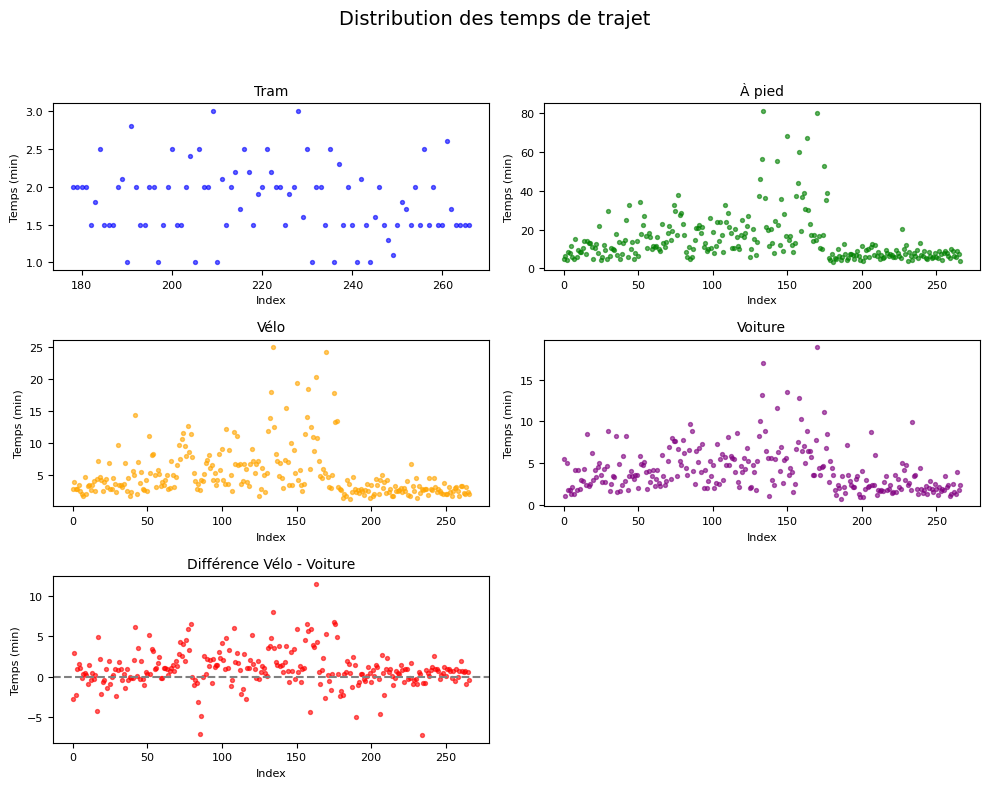

In [29]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Charger les données
gdf = gpd.read_file("trajets_jointure_strasbourg.shp")

# Créer 5 sous-graphiques (3 lignes x 2 colonnes, la dernière cellule vide)
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
fig.suptitle("Distribution des temps de trajet", fontsize=14)

# Liste des colonnes et des couleurs
cols = [
    ("tram_min", "blue", "Tram"),
    ("pieds_min", "green", "À pied"),
    ("velo_min", "orange", "Vélo"),
    ("voiture_mi", "purple", "Voiture"),
    ("d_vel_voi", "red", "Différence Vélo - Voiture"),
]

# Tracer chaque nuage de points
for i, (col, color, title) in enumerate(cols):
    row, col_pos = divmod(i, 2)
    ax = axs[row, col_pos]
    ax.scatter(range(len(gdf)), gdf[col], color=color, alpha=0.6, s=8)
    ax.set_title(title, fontsize=10)
    ax.set_ylabel("Temps (min)", fontsize=8)
    ax.set_xlabel("Index", fontsize=8)
    ax.tick_params(labelsize=8)
    if title == "Différence Vélo - Voiture":
        ax.axhline(0, color='gray', linestyle='--')

# Supprimer la dernière cellule vide (en bas à droite)
axs[2, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### **Carte : échelle 2 * Il suffit de faire juste cette partie**

In [32]:
import geopandas as gpd
import folium
from folium import FeatureGroup
import math
import pandas as pd
from branca.element import Element
from branca.element import MacroElement
from jinja2 import Template

# --- Charger les données ---
gdf_all = gpd.read_file("trajets_jointure_strasbourg.shp")
poi = gpd.read_file("POI_Strasbourg_final_4326.shp")
velhop = gpd.read_file("stations-velhop.shp")
stations = gpd.read_file("stations_velo.shp")
epci = gpd.read_file("ZE_EPCI.shp").to_crs(epsg=4326)
communes = gpd.read_file("ZE_commune.shp").to_crs(epsg=4326)

# --- Liste des IDs à exclure ---
ids_a_ignorer = [221, 222, 180, 181]  # à adapter selon ton besoin

# --- Initialiser la carte ---
m = folium.Map(location=[48.583732, 7.7448333], zoom_start=14, tiles=None)

# --- Fonds de carte ---
folium.TileLayer(
    'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
    name='Humanitarian', attr='© Données GTFS(CTS) & IGN & Eurométropole de Strasbourg, Calculé par ORS', opacity=0.4
).add_to(m)
folium.TileLayer(
    'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    name='OSM Standard', attr='© Données GTFS(CTS) & IGN & Eurométropole de Strasbourg, Calculé par ORS', opacity=0.4
).add_to(m)
folium.TileLayer(
    'CartoDB positron', attr='© Données GTFS(CTS) & IGN & Eurométropole de Strasbourg, Calculé par ORS', name='Fond clair', opacity=1
).add_to(m)

# --- Fonctions utiles ---
def get_color(time):
    if time <= 5:
        return 'dodgerblue'
    elif time <= 10:
        return 'mediumblue'
    elif time <= 15:
        return 'darkorange'
    else:
        return 'firebrick'

def get_style(source, color):
    if source == 'tram':
        return {'color': color, 'weight': 4, 'dashArray': '0'}
    else:
        return {'color': color, 'weight': 4, 'dashArray': '5, 5'}

def add_mode_layer(gdf, mode_col, layer_name, show=False):
    fg = FeatureGroup(name=layer_name, show=show)
    gdf_mode = gdf[gdf[mode_col].notna() & (gdf[mode_col] > 0)].copy()

    for _, row in gdf_mode.iterrows():
        if row['id'] in ids_a_ignorer:
            continue  # <<< IGNORE CES SEGMENTS
        time_mode = float(row[mode_col])
        color = get_color(time_mode)
        style = get_style(row['source'], color)

        popup_html = (
            f"<b>ID :</b> {row['id']}<br>"
            f"<b>Vélo :</b> {row['velo_min'] if pd.notna(row['velo_min']) else 'N/A'} min<br>"
            f"<b>Pied :</b> {row['pieds_min'] if pd.notna(row['pieds_min']) else 'N/A'} min<br>"
            f"<b>Voiture :</b> {row['voiture_mi'] if pd.notna(row['voiture_mi']) else 'N/A'} min<br>"
            f"<b>Tram :</b> {row['tram_min'] if pd.notna(row['tram_min']) else 'N/A'} min"
        )

        folium.GeoJson(
            row.geometry,
            style_function=lambda x, style=style: style,
            tooltip=popup_html
        ).add_to(fg)

        mid_point = row.geometry.interpolate(0.5, normalized=True)
        icon_html = f"""
        <div style="
            font-size: 16px;
            font-weight: bold;
            color: white;
            text-shadow: -1px -1px {color}, 1px -1px {color}, -1px 1px {color}, 1px 1px {color};">
            {math.ceil(time_mode)}
        </div>"""
        folium.Marker(
            location=[mid_point.y, mid_point.x],
            icon=folium.DivIcon(html=icon_html)
        ).add_to(fg)

    fg.add_to(m)

# --- Couches des modes ---
add_mode_layer(gdf_all, 'velo_min', "Trajets Vélo", show=True)
# add_mode_layer(gdf_all, 'pieds_min', "Trajets à Pied", show=False)
add_mode_layer(gdf_all, 'voiture_mi', "Trajets Voiture", show=False)

# --- Couche de différence Vélo - Voiture ---
def add_d_vel_voi_layer(gdf, layer_name="Différence Vélo - Voiture", show=False):
    fg = folium.FeatureGroup(name=layer_name, show=show)
    gdf_mode = gdf[gdf['d_vel_voi'].notna()].copy()

    for _, row in gdf_mode.iterrows():
        if row['id'] in ids_a_ignorer:
            continue  # <<< IGNORE CES SEGMENTS
        diff_real = float(row['d_vel_voi'])
        diff_round = math.ceil(diff_real)

        # Couleur selon diff_round
        if diff_round <= -5:
            color = 'green'
        elif -5 < diff_round <= -1:
            color = 'limegreen'
        elif diff_round == 0:
            color = 'gold'
        elif 1 <= diff_round <= 5:
            color = 'hotpink'
        else:
            color = 'mediumvioletred'

        # TRAIT NORMAL (pas de pointillés)
        style = {
            'color': color,
            'weight': 4
        }

        popup_html = (
            f"<b>Vélo :</b> {row['velo_min'] if pd.notna(row['velo_min']) else 'N/A'} min<br>"
            f"<b>Voiture :</b> {row['voiture_mi'] if pd.notna(row['voiture_mi']) else 'N/A'} min<br>"
            f"<b>Différence Vélo - Voiture :</b> {diff_real:.2f} min"
        )

        folium.GeoJson(
            row.geometry,
            style_function=lambda x, style=style: style,
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(fg)

        # Étiquette numérique
        mid_point = row.geometry.interpolate(0.5, normalized=True)
        icon_html = f"""
        <div style="
            font-size: 15px;
            font-weight: bold;
            color: white;
            text-shadow: -1px -1px {color}, 1px -1px {color}, -1px 1px {color}, 1px 1px {color};">
            {diff_round}
        </div>"""
        folium.Marker(
            location=[mid_point.y, mid_point.x],
            icon=folium.DivIcon(html=icon_html)
        ).add_to(fg)

    fg.add_to(m)

add_d_vel_voi_layer(gdf_all, layer_name="Différence Vélo - Voiture", show=False)

##########################################
# --- POI avec icônes spécifiques ---
poi_group = FeatureGroup(name="POI", show=True)
for _, row in poi.iterrows():
    nom = row['nom'].lower()
    if 'train' in nom:
        icon_type = 'train'
    elif 'aéro' in nom:
        icon_type = 'plane'
    else:
        icon_type = None

    if icon_type:
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            icon=folium.Icon(icon=icon_type, prefix="fa", color="black"),
            popup=row['nom'],
        ).add_to(poi_group)
    else:
        color = 'black' if row['type'].lower() == 'transport' else 'white'
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=4.5 if row['type'].lower() == 'transport' else 4,
            color='black',
            fill=True,
            fill_color=color,
            fill_opacity=1,
            weight=1,
            popup=row['nom'],
        ).add_to(poi_group)

poi_group.add_to(m)

# --- Stations Velhop ---
velhop_group = FeatureGroup(name="Stations Velhop", show=False)
for _, row in velhop.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color="green", icon="bicycle", prefix="fa"),
    ).add_to(velhop_group)
velhop_group.add_to(m)

# --- Stations de gonflage et d'outils ---
stations_group = FeatureGroup(name="Stations de gonflage et d'outils", show=False)
for _, row in stations.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="darkgreen",
        fill=True,
        fill_color="darkgreen",
        fill_opacity=1
    ).add_to(stations_group)
stations_group.add_to(m)

# --- Limites EPCI et Communes ---
epci_group = FeatureGroup(name="EPCI", show=False)
folium.GeoJson(epci, style_function=lambda x: {'color': 'black', 'weight': 1, 'fillOpacity': 0}).add_to(epci_group)
epci_group.add_to(m)

commune_group = FeatureGroup(name="Communes", show=False)
folium.GeoJson(communes, style_function=lambda x: {'color': 'gray', 'weight': 1, 'fillOpacity': 0}).add_to(commune_group)
commune_group.add_to(m)

# --- Contrôle des couches ---
folium.LayerControl(collapsed=False).add_to(m)

# --- Légende ---
legend_html = """
<div style='
    position: fixed;
    bottom: 30px;
    left: 30px;
    width: 260px;
    background-color: rgba(255, 255, 255, 0.85);
    border: 1px solid gray;
    z-index: 9999;
    font-size: 13px;
    padding: 10px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
'>
    <u>POI</u><br>
    <svg width="16" height="16"><circle cx="8" cy="8" r="5" fill="white" stroke="black" stroke-width="1"/></svg>
    Sites emblématiques<br>

    <svg width="16" height="16"><circle cx="8" cy="8" r="5" fill="black"/></svg>
    Arrêts bus/tram<br>

    <i class="fa fa-train" style="color:black;"></i> /
    <i class="fa fa-plane" style="color:black;"></i>
    Gare / Aéroport<br><br>

    <u>Temps de déplacement</u><br>
    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:black;stroke-width:6" /></svg>
    Tram<br>
    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:black;stroke-width:6;stroke-dasharray:5,5" /></svg>
    Tram non dispo<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:dodgerblue;stroke-width:6" /></svg>
    ≤ 5 min<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:mediumblue;stroke-width:6" /></svg>
    ≤ 10 min<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:darkorange;stroke-width:6" /></svg>
    ≤ 15 min<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:firebrick;stroke-width:6" /></svg>
    > 15 min<br>

        <br><u>Diff. Vélo - Voiture</u><br>
    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:mediumvioletred;stroke-width:6" /></svg>
> 5 min (vélo plus long)<br>
<svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:hotpink;stroke-width:6" /></svg>
0 < ≤ 5 min <br> (vélo un peu plus long)<br>
<svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:gold;stroke-width:6" /></svg>
0 min (égalité) <br>
<svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:limegreen;stroke-width:6" /></svg>
-5 ≤ < 0 min <br> (vélo un peu plus rapide) <br>
<svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:green;stroke-width:6" /></svg>
< -5 min (vélo plus rapide)<br>

</div>
"""
m.get_root().html.add_child(Element(legend_html))

# --- Bouton Réinitialiser la carte ---
reset_button_html = """
<div style="
     position: fixed;
     top: 90px;
     left: 10px;
     z-index: 9999;
     background-color: white;
     border: 2px solid gray;
     padding: 6px 10px;
     border-radius: 5px;
     box-shadow: 1px 1px 5px rgba(0,0,0,0.4);
     font-size: 14px;
     cursor: pointer;">
    <a href="javascript:location.reload();" style="text-decoration: none; color: black;">
        🔄 Réinitialiser la carte
    </a>
</div>
"""
m.get_root().html.add_child(Element(reset_button_html))

# --- Bouton d'aide info ---
info_button_html = """
<div style="position: fixed; top: 130px; left: 10px; z-index: 9999;">
    <div id="infoToggle" style="
        background-color: white;
        border: 1px solid gray;
        padding: 6px 10px;
        border-radius: 5px;
        box-shadow: 1px 1px 4px rgba(0,0,0,0.3);
        font-size: 14px;
        cursor: pointer;
        width: auto;">
        ℹ️ <b>Afficher l'aide</b>
    </div>
    <div id="infoContent" style="
        display: none;
        margin-top: 5px;
        background-color: white;
        border: 1px solid gray;
        padding: 10px;
        border-radius: 5px;
        width: 230px;
        box-shadow: 1px 1px 4px rgba(0,0,0,0.3);
        font-size: 14px;">
        🔄 Réinitialiser la carte<br>
        ➕ Zoomez/Dézoomez<br>
        🗺️ Fond de carte modifiable<br>
        ✅ Activez/Désactivez les couches<br>
        ➖ Cliquez : temps de trajet<br>
        🟡 Cliquez : noms de POIs<br>
        🟡 POIs toujours devant<br>
    </div>
</div>

<script>
    document.getElementById("infoToggle").onclick = function() {
        var content = document.getElementById("infoContent");
        if (content.style.display === "none") {
            content.style.display = "block";
            this.innerHTML = "❌ <b>Fermer l'aide</b>";
        } else {
            content.style.display = "none";
            this.innerHTML = "ℹ️ <b>Afficher l'aide</b>";
        }
    };
</script>
"""
info_button = MacroElement()
info_button._template = Template(f"""{{% macro html(this, kwargs) %}}{info_button_html}{{% endmacro %}}""")
m.get_root().add_child(info_button)

##############


# --- Afficher la carte ---
m

In [33]:
# --- Affichage ou export ---
m.save("carte_finale_réseaux.html")

In [34]:
output_gpkg = "carte_finale_réseaux_shp.gpkg"

gdf_all.to_file(output_gpkg, layer='trajets_jointure_strasbourg', driver="GPKG")
poi.to_file(output_gpkg, layer='poi', driver="GPKG")
velhop.to_file(output_gpkg, layer='velhop', driver="GPKG")
stations.to_file(output_gpkg, layer='stations_gonflage', driver="GPKG")
epci.to_file(output_gpkg, layer='epci', driver="GPKG")
communes.to_file(output_gpkg, layer='communes', driver="GPKG")

## Echelle1 : Centre

### Carte : échelle 1 * Il suffit de faire juste cette partie

In [35]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import folium
from folium import FeatureGroup
import pandas as pd
import math

# --- Coordonnées et tampon 3km ---
centre_coords = [48.583732, 7.7448333]
centre_point = gpd.GeoDataFrame(geometry=[Point(centre_coords[1], centre_coords[0])], crs="EPSG:4326")
centre_m = centre_point.to_crs(epsg=2154)
buffer_m = centre_m.buffer(3000)
buffer_wgs84 = gpd.GeoDataFrame(geometry=buffer_m.to_crs(epsg=4326), crs="EPSG:4326")
buffer_geom = buffer_wgs84.geometry.iloc[0]

# --- Charger données ---
gdf_all = gpd.read_file("trajets_jointure_strasbourg.shp")
poi = gpd.read_file("POI_Strasbourg_final_4326.shp")
velhop = gpd.read_file("stations-velhop.shp")
stations = gpd.read_file("stations_velo.shp")
epci = gpd.read_file("ZE_EPCI.shp").to_crs(epsg=4326)
communes = gpd.read_file("ZE_commune.shp").to_crs(epsg=4326)


# --- Filtrer trajets dont les 2 extrémités sont dans le buffer ---
def segment_entier(row):
    if row.geometry.is_empty:
        return False
    if isinstance(row.geometry, LineString):
        coords = list(row.geometry.coords)
        start, end = Point(coords[0]), Point(coords[-1])
        return buffer_geom.contains(start) and buffer_geom.contains(end)
    return False

gdf_segments_entiers = gdf_all[gdf_all.apply(segment_entier, axis=1)].copy()



# --- Liste des IDs à exclure ---
ids_a_ignorer = [221, 222, 180, 181]  # à adapter selon ton besoin

# --- Fonction styles trajets ---
def get_color(time):
    if time <= 5:
        return 'dodgerblue'
    elif time <= 10:
        return 'mediumblue'
    elif time <= 15:
        return 'darkorange'
    else:
        return 'firebrick'

def get_style(source, color):
    if source == 'tram':
        return {'color': color, 'weight': 4, 'dashArray': '0'}
    else:
        return {'color': color, 'weight': 4, 'dashArray': '5, 5'}

# --- Fonction pour ajouter une couche trajets ---
def add_mode_layer(gdf, mode_col, layer_name, show=False, m=None):
    fg = FeatureGroup(name=layer_name, show=show)
    gdf_mode = gdf[gdf[mode_col].notna() & (gdf[mode_col] > 0)].copy()

    for _, row in gdf_mode.iterrows():
        if row['id'] in ids_a_ignorer:
            continue  # <<< IGNORE CES SEGMENTS
        time_mode = float(row[mode_col])
        color = get_color(time_mode)
        style = get_style(row.get('source', ''), color)

        popup_html = (
            f"<b>ID :</b> {row['id']}<br>"
            f"<b>Vélo :</b> {row['velo_min'] if pd.notna(row['velo_min']) else 'N/A'} min<br>"
            f"<b>Pied :</b> {row['pieds_min'] if pd.notna(row['pieds_min']) else 'N/A'} min<br>"
            f"<b>Voiture :</b> {row['voiture_mi'] if pd.notna(row['voiture_mi']) else 'N/A'} min<br>"
            f"<b>Tram :</b> {row['tram_min'] if pd.notna(row['tram_min']) else 'N/A'} min"
        )

        folium.GeoJson(
            row.geometry,
            style_function=lambda x, style=style: style,
            tooltip=popup_html
        ).add_to(fg)

        mid_point = row.geometry.interpolate(0.5, normalized=True)
        icon_html = f"""
        <div style="
            font-size: 16px;
            font-weight: bold;
            color: white;
            text-shadow: -1px -1px {color}, 1px -1px {color}, -1px 1px {color}, 1px 1px {color};">
            {math.ceil(time_mode)}
        </div>"""
        folium.Marker(
            location=[mid_point.y, mid_point.x],
            icon=folium.DivIcon(html=icon_html)
        ).add_to(fg)
    fg.add_to(m_centre)

# --- Carte centrée ---
m_centre = folium.Map(location=centre_coords, zoom_start=15, tiles=None)


# --- Fonds de carte ---  # --- copylight ---
folium.TileLayer(
    'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
    name='Humanitarian', attr='© Crée en 2025, Données par GTFS(CTS) & IGN & Eurométropole de Strasbourg, Calculé par ORS', opacity=0.4
).add_to(m_centre)
folium.TileLayer(
    'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    name='OSM Standard', attr='© Crée en 2025, Données par GTFS(CTS) & IGN & Eurométropole de Strasbourg, Calculé par ORS', opacity=0.4
).add_to(m_centre)
folium.TileLayer(
    'CartoDB positron', name='Fond clair',attr='© Crée en 2025, Données par GTFS(CTS) & IGN & Eurométropole de Strasbourg, Calculé par ORS', opacity=1
).add_to(m_centre)

# --- Ajouter trajets ---
add_mode_layer(gdf_segments_entiers, 'velo_min', "Trajets Vélo", show=True, m=m_centre)
add_mode_layer(gdf_segments_entiers, 'pieds_min', "Trajets à Pied", show=False, m=m_centre)
add_mode_layer(gdf_segments_entiers, 'voiture_mi', "Trajets Voiture", show=False, m=m_centre)

# --- POI découpés dans buffer ---
poi_clip = poi[poi.geometry.within(buffer_geom)]
poi_group = FeatureGroup(name="POI", show=True)
for _, row in poi_clip.iterrows():
    nom = row['nom'].lower()
    if 'train' in nom:
        icon_type = 'train'
    elif 'aéro' in nom:
        icon_type = 'plane'
    else:
        icon_type = None

    if icon_type:
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            icon=folium.Icon(icon=icon_type, prefix="fa", color="black"),
            popup=row['nom']
        ).add_to(poi_group)
    else:
        color = 'black' if row['type'].lower() == 'transport' else 'white'
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5 if row['type'].lower() == 'transport' else 4,
            color='black',
            fill=True,
            fill_color=color,
            fill_opacity=1,
            popup=row['nom']
        ).add_to(poi_group)
poi_group.add_to(m_centre)

# --- Stations Velhop découpées ---
velhop_clip = velhop[velhop.geometry.within(buffer_geom)]
velhop_group_centre = FeatureGroup(name="Stations Velhop", show=False)
for _, row in velhop_clip.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color="green", icon="bicycle", prefix="fa"),
    ).add_to(velhop_group_centre)
velhop_group_centre.add_to(m_centre)

# --- Stations gonflage découpées ---
stations_clip = stations[stations.geometry.within(buffer_geom)]
stations_group_centre = FeatureGroup(name="Stations de gonflage et d'outils", show=False)
for _, row in stations_clip.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="darkgreen",
        fill=True,
        fill_color="darkgreen",
        fill_opacity=1
    ).add_to(stations_group_centre)
stations_group_centre.add_to(m_centre)

# --- EPCI non découpés ---
epci_group_centre = FeatureGroup(name="EPCI", show=False)
folium.GeoJson(
    epci,
    style_function=lambda x: {'color': 'black', 'weight': 1, 'fillOpacity': 0}
).add_to(epci_group_centre)
epci_group_centre.add_to(m_centre)

# --- Communes non découpées ---
commune_group_centre = FeatureGroup(name="Communes", show=False)
folium.GeoJson(
    communes,
    style_function=lambda x: {'color': 'gray', 'weight': 1, 'fillOpacity': 0}
).add_to(commune_group_centre)
commune_group_centre.add_to(m_centre)

# --- Contrôle des couches ---
folium.LayerControl().add_to(m_centre)

# --- Légende ---
legend_html = """
<div style='
    position: fixed;
    bottom: 30px;
    left: 30px;
    width: 260px;
    background-color: rgba(255, 255, 255, 0.85);
    border: 1px solid gray;
    z-index: 9999;
    font-size: 13px;
    padding: 10px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
'>
    <u>POI</u><br>
    <svg width="16" height="16"><circle cx="8" cy="8" r="5" fill="white" stroke="black" stroke-width="1"/></svg>
    Sites emblématiques<br>

    <svg width="16" height="16"><circle cx="8" cy="8" r="5" fill="black"/></svg>
    Arrêts bus/tram<br>

    <i class="fa fa-train" style="color:black;"></i> /
    <i class="fa fa-plane" style="color:black;"></i>
    Gare / Aéroport<br><br>

    <u>Temps de déplacement</u><br>
    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:black;stroke-width:6" /></svg>
    Tram<br>
    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:black;stroke-width:6;stroke-dasharray:5,5" /></svg>
    Tram non dispo<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:dodgerblue;stroke-width:6" /></svg>
    ≤ 5 min<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:mediumblue;stroke-width:6" /></svg>
    ≤ 10 min<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:darkorange;stroke-width:6" /></svg>
    ≤ 15 min<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:firebrick;stroke-width:6" /></svg>
    > 15 min<br>
</div>
"""
m_centre.get_root().html.add_child(Element(legend_html))

# --- Bouton Réinitialiser la carte ---
reset_button_html = """
<div style="
     position: fixed;
     top: 90px;
     left: 10px;
     z-index: 9999;
     background-color: white;
     border: 2px solid gray;
     padding: 6px 10px;
     border-radius: 5px;
     box-shadow: 1px 1px 5px rgba(0,0,0,0.4);
     font-size: 14px;
     cursor: pointer;">
    <a href="javascript:location.reload();" style="text-decoration: none; color: black;">
        🔄 Réinitialiser la carte
    </a>
</div>
"""
m_centre.get_root().html.add_child(Element(reset_button_html))

# --- Bouton d'aide info ---
info_button_html = """
<div style="position: fixed; top: 130px; left: 10px; z-index: 9999;">
    <div id="infoToggle" style="
        background-color: white;
        border: 1px solid gray;
        padding: 6px 10px;
        border-radius: 5px;
        box-shadow: 1px 1px 4px rgba(0,0,0,0.3);
        font-size: 14px;
        cursor: pointer;
        width: auto;">
        ℹ️ <b>Afficher l'aide</b>
    </div>
    <div id="infoContent" style="
        display: none;
        margin-top: 5px;
        background-color: white;
        border: 1px solid gray;
        padding: 10px;
        border-radius: 5px;
        width: 230px;
        box-shadow: 1px 1px 4px rgba(0,0,0,0.3);
        font-size: 14px;">
        🔄 Réinitialiser la carte<br>
        ➕ Zoomez/Dézoomez<br>
        🗺️ Fond de carte modifiable<br>
        ✅ Activez/Désactivez les couches<br>
        ➖ Cliquez : temps de trajet<br>
        🟡 Cliquez : noms de POIs<br>
        🟡 POIs toujours devant<br>
    </div>
</div>

<script>
    document.getElementById("infoToggle").onclick = function() {
        var content = document.getElementById("infoContent");
        if (content.style.display === "none") {
            content.style.display = "block";
            this.innerHTML = "❌ <b>Fermer l'aide</b>";
        } else {
            content.style.display = "none";
            this.innerHTML = "ℹ️ <b>Afficher l'aide</b>";
        }
    };
</script>
"""
info_button = MacroElement()
info_button._template = Template(f"""{{% macro html(this, kwargs) %}}{info_button_html}{{% endmacro %}}""")
m_centre.get_root().add_child(info_button)

##############


# --- Afficher la carte ---
m_centre


In [36]:
# --- Affichage ou export ---
m_centre.save("carte_finale_centre.html")

In [37]:
output_gpkg = "carte_finale_centre_shp.gpkg"

gdf_segments_entiers.to_file(output_gpkg, layer='trajets', driver="GPKG")
poi.to_file(output_gpkg, layer='poi', driver="GPKG")
velhop.to_file(output_gpkg, layer='velhop', driver="GPKG")
stations.to_file(output_gpkg, layer='stations_gonflage', driver="GPKG")
epci.to_file(output_gpkg, layer='epci', driver="GPKG")
communes.to_file(output_gpkg, layer='communes', driver="GPKG")

# **4. Prétraitements des données (échelle3)**

In [ ]:
# Charger la couche de segments
segments = gpd.read_file("segments_EMS_2154.shp")

# Reprojeter en WGS84 pour extraire les lat/lon
segments = segments.to_crs("EPSG:4326")

# Préparer les colonnes
data = []
for idx, row in segments.iterrows():
    line = row.geometry
    if line is not None and line.geom_type == 'LineString':
        start = line.coords[0]
        end = line.coords[-1]
        data.append({
            "from_stop_name": f"stop_{idx}_A",  # à personnaliser
            "to_stop_name": f"stop_{idx}_B",    # à personnaliser
            "route_type": "manu",
            "from_lat": start[1],
            "from_lon": start[0],
            "to_lat": end[1],
            "to_lon": end[0],
            "tram_min": None,
            "pieds_min": None,
            "velo_min": None,
            "voiture_min": None
        })

# Convertir en DataFrame
df = pd.DataFrame(data)

# Afficher les 5 premières lignes
print(df.head())


  from_stop_name to_stop_name route_type   from_lat  from_lon     to_lat  \
0       stop_0_A     stop_0_B       manu  48.685114  7.698114  48.672793   
1       stop_1_A     stop_1_B       manu  48.672793  7.703946  48.665414   
2       stop_2_A     stop_2_B       manu  48.665414  7.718221  48.656724   
3       stop_3_A     stop_3_B       manu  48.656724  7.721946  48.650860   
4       stop_4_A     stop_4_B       manu  48.650860  7.699677  48.641720   

     to_lon tram_min pieds_min velo_min voiture_min  
0  7.703946     None      None     None        None  
1  7.718221     None      None     None        None  
2  7.721946     None      None     None        None  
3  7.699677     None      None     None        None  
4  7.714999     None      None     None        None  


In [ ]:
print(f"Nombre de segments : {segments.shape[0]}")

Nombre de segments : 91


In [ ]:
# --- Export final ---
df.to_csv('segments_EMS_coordonnees.csv', index=False, encoding='utf-8-sig')
print("✅ Fichier enregistré : segments_EMS_coordonnees.csv")

✅ Fichier enregistré : segments_EMS_coordonnees.csv


# **5. ORS : Calculer le temps des trajets (échelle3)**




In [38]:
!pip install openrouteservice
import openrouteservice
import numpy as np
import pandas as pd

2mins 500>452

In [ ]:
df = pd.read_csv("segments_EMS_coordonnees.csv")

# === Paramètres ===
ORS_API_KEY = "5b3ce3597851110001cf6248000fc647f85c43309e7b2f6f9c68bfc0"
MAX_SIZE = 59  # max 59x59 = 3481
PROFILES = ['foot-walking', 'cycling-regular', 'driving-car']

# === ORS client ===
client = openrouteservice.Client(key=ORS_API_KEY)

# Construire la table des arrêts uniques (stop_name + coords)
# Concaténer tous les points de départ et d'arrivée
coord_df = pd.DataFrame({
    'stop_name': df['from_stop_name'].tolist() + df['to_stop_name'].tolist(),
    'lat': df['from_lat'].tolist() + df['to_lat'].tolist(),
    'lon': df['from_lon'].tolist() + df['to_lon'].tolist()
}).drop_duplicates().dropna().reset_index(drop=True)

# Préparer les coordonnées au format ORS (lon, lat)
coords = list(zip(coord_df['lon'], coord_df['lat']))


# === Fonction de découpage en blocs ORS-safe ===
def split_blocks(data, size):
    for i in range(0, len(data), size):
        for j in range(0, len(data), size):
            sources = list(range(i, min(i+size, len(data))))
            destinations = list(range(j, min(j+size, len(data))))
            yield sources, destinations

# === Fonction de requête ORS matrix ===
def get_matrix_sub(client, coords, sources, destinations, profile):
    matrix = client.distance_matrix(
        locations=coords,
        profile=profile,
        metrics=['duration'],
        sources=sources,
        destinations=destinations,
        resolve_locations=False
    )
    return np.array(matrix['durations'])

# === Calculer matrices par profil ===
matrices = {}
for profile in PROFILES:
    print(f"Calcul de la matrice pour : {profile}")
    full_matrix = np.full((len(coords), len(coords)), np.nan)

    for sources, destinations in split_blocks(coords, MAX_SIZE):
        try:
            sub_matrix = get_matrix_sub(client, coords, sources, destinations, profile)
            for si, s in enumerate(sources):
                for di, d in enumerate(destinations):
                    full_matrix[s, d] = sub_matrix[si, di]
        except Exception as e:
            print(f"Erreur sur bloc {sources[0]}-{sources[-1]} x {destinations[0]}-{destinations[-1]} : {e}")

    matrices[profile] = pd.DataFrame(
        full_matrix,
        index=coord_df['stop_name'],
        columns=coord_df['stop_name']
    )

# === Sauvegarde des résultats ===
for profile in PROFILES:
    filename = f"matrix_durations_EMS_{profile.replace('-', '_')}.csv"
    matrices[profile].to_csv(filename, encoding='utf-8-sig')
    print(f"✅ Matrice enregistrée : {filename}")

Calcul de la matrice pour : foot-walking
Calcul de la matrice pour : cycling-regular
Calcul de la matrice pour : driving-car


/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rat

✅ Matrice enregistrée : matrix_durations_EMS_foot_walking.csv
✅ Matrice enregistrée : matrix_durations_EMS_cycling_regular.csv
✅ Matrice enregistrée : matrix_durations_EMS_driving_car.csv


In [39]:
import pandas as pd

# --- Charger les trajets tram (segments_coordonnees.csv ou trajets_tram.csv) ---
df = pd.read_csv('segments_EMS_coordonnees.csv')

# --- Charger les matrices ORS ---
df_foot = pd.read_csv('matrix_durations_EMS_foot_walking.csv', index_col=0)
df_bike = pd.read_csv('matrix_durations_EMS_cycling_regular.csv', index_col=0)
df_car = pd.read_csv('matrix_durations_EMS_driving_car.csv', index_col=0)

# --- Convertir les durées de secondes en minutes ---
df_foot = df_foot / 60
df_bike = df_bike / 60
df_car = df_car / 60

# --- Fonction moyenne symétrique (aller + retour) ---
def get_symmetric_avg_duration(row, matrix):
    from_stop = row['from_stop_name']
    to_stop = row['to_stop_name']
    try:
        d1 = matrix.loc[from_stop, to_stop]
    except KeyError:
        d1 = None
    try:
        d2 = matrix.loc[to_stop, from_stop]
    except KeyError:
        d2 = None

    values = [d for d in [d1, d2] if pd.notna(d)]
    if not values:
        return None
    return round(sum(values) / len(values), 1)

# --- Ajouter les colonnes de temps symétriques ---
df['pieds_min'] = df.apply(lambda row: get_symmetric_avg_duration(row, df_foot), axis=1)
df['velo_min'] = df.apply(lambda row: get_symmetric_avg_duration(row, df_bike), axis=1)
df['voiture_min'] = df.apply(lambda row: get_symmetric_avg_duration(row, df_car), axis=1)

# --- Renommer la colonne tram_min si besoin ---
if 'travel_time_min' in df.columns:
    df = df.rename(columns={'travel_time_min': 'tram_min'})

# --- Sélectionner colonnes dans l'ordre voulu ---
colonnes_finales = ['from_stop_name', 'to_stop_name', 'route_type',
                    'from_lat', 'from_lon', 'to_lat', 'to_lon',
                    'tram_min', 'pieds_min', 'velo_min', 'voiture_min']

df_final = df[colonnes_finales].copy()

# --- Ajouter une colonne id unique ---
df_final['id'] = df_final.index.astype(int)

# --- Réorganiser avec id en première colonne ---
cols_final = ['id'] + colonnes_finales
df_final = df_final[cols_final]

# --- Export CSV final ---
df_final.to_csv('trajets_EMS_comparaison_modes.csv', index=False, encoding='utf-8-sig')
print("✅ Fichier enrichi enregistré : trajets_EMS_comparaison_modes.csv")


✅ Fichier enrichi enregistré : trajets_EMS_comparaison_modes.csv


# **6. Cartographie (échelle3)**

In [40]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString

# Charger les données
df = pd.read_csv("trajets_EMS_comparaison_modes.csv")

# Créer une colonne geometry avec des LineStrings
geometry = [
    LineString([(row['from_lon'], row['from_lat']), (row['to_lon'], row['to_lat'])])
    for _, row in df.iterrows()
]

# Créer GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Ajouter la différence de temps vélo - voiture
gdf['d_vel_voi'] = gdf['velo_min'] - gdf['voiture_min']

# Sauvegarder en Shapefile
gdf.to_file("trajets_EMS_lignes.shp", driver="ESRI Shapefile")

# Sauvegarder aussi en CSV avec la géométrie en WKT
gdf_copy = gdf.copy()
gdf_copy['geometry'] = gdf_copy['geometry'].apply(lambda geom: geom.wkt)
gdf_copy.to_csv("trajets_EMS_lignes.csv", index=False)

/tmp/ipython-input-40-3971106032.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("trajets_EMS_lignes.shp", driver="ESRI Shapefile")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'from_stop_name' to 'from_stop_'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'to_stop_name' to 'to_stop_na'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'voiture_min' to 'voiture_mi'
  ogr_write(
/tmp/ipython-input-40-3971106032.py:25: UserWarning: Geometry column does not contain geometry.
  gdf_copy['geometry'] = gdf_copy['geometry'].apply(lambda geom: geom.wkt)


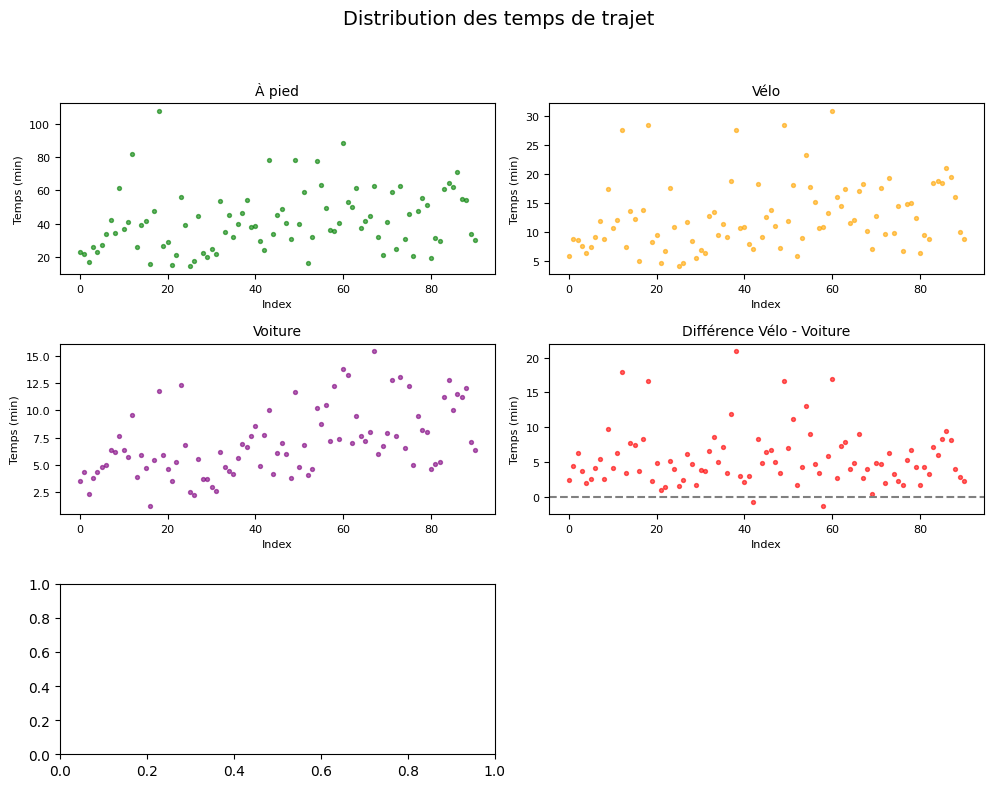

In [41]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Charger les données
gdf = gpd.read_file("trajets_EMS_lignes.shp")

# Créer 5 sous-graphiques (3 lignes x 2 colonnes, la dernière cellule vide)
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
fig.suptitle("Distribution des temps de trajet", fontsize=14)

# Liste des colonnes et des couleurs
cols = [
    #("tram_min", "blue", "Tram"),
    ("pieds_min", "green", "À pied"),
    ("velo_min", "orange", "Vélo"),
    ("voiture_mi", "purple", "Voiture"),
    ("d_vel_voi", "red", "Différence Vélo - Voiture"),
]

# Tracer chaque nuage de points
for i, (col, color, title) in enumerate(cols):
    row, col_pos = divmod(i, 2)
    ax = axs[row, col_pos]
    ax.scatter(range(len(gdf)), gdf[col], color=color, alpha=0.6, s=8)
    ax.set_title(title, fontsize=10)
    ax.set_ylabel("Temps (min)", fontsize=8)
    ax.set_xlabel("Index", fontsize=8)
    ax.tick_params(labelsize=8)
    if title == "Différence Vélo - Voiture":
        ax.axhline(0, color='gray', linestyle='--')

# Supprimer la dernière cellule vide (en bas à droite)
axs[2, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [46]:
import geopandas as gpd
import folium
from folium import FeatureGroup
import math
import pandas as pd

# Charger shapefile commun
gdf_all = gpd.read_file("trajets_EMS_lignes.shp")

# --- Charger les POI ---
poi = gpd.read_file("fusion_POI_EMS_4326.shp")

# Centrer la carte avec union_all()
#geom_union = gdf_all.geometry.union_all()
#centroid = geom_union.centroid
centroid = gdf_all.geometry.unary_union.centroid
m_EPCI = folium.Map(location=[48.583328, 7.6833], zoom_start=11.5, tiles=None)

# --- Fonds de carte ---
folium.TileLayer(
    'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
    name='Humanitarian', attr='© Crée en 2025, Données par GTFS(CTS) & IGN & Eurométropole de Strasbourg, Calculé par ORS', opacity=0.4
).add_to(m_EPCI)
folium.TileLayer(
    'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    name='OSM Standard', attr='© Crée en 2025, Données par GTFS(CTS) & IGN & Eurométropole de Strasbourg, Calculé par ORS', opacity=0.4
).add_to(m_EPCI)
folium.TileLayer(
    'CartoDB positron', attr='© Crée en 2025, Données par GTFS(CTS) & IGN & Eurométropole de Strasbourg, Calculé par ORS',  name='Fond clair', opacity=1
).add_to(m_EPCI)

#########################################################
# --- Fonction couleurs selon temps ---
def get_color(time):
    if time <= 5:
        return 'dodgerblue'
    elif time <= 10:
        return 'mediumblue'
    elif time <= 15:
        return 'darkorange'
    else:
        return 'firebrick'

# Style unique: dashArray '5,5' pour tous
def get_style(color):
    return {'color': color, 'weight': 5, 'dashArray': '5'}

def make_style_func(style_dict):
    def style_function(feature):
        return style_dict
    return style_function


# Style pour différence des temps
def get_color_d_vel_voi(diff):
    if diff > 5:
        return 'mediumvioletred'
    elif 0 < diff <= 5:
        return 'hotpink'
    elif diff == 0:
        return 'gold'
    else:
        return 'limegreen'

###############################################################
# --- Fonction pour ajouter les couches par mode ---
def add_mode_layer(gdf, mode_col, layer_name, show=False):
    fg = FeatureGroup(name=layer_name, show=show)
    gdf_mode = gdf[gdf[mode_col].notna() & (gdf[mode_col] > 0)].copy()

    for _, row in gdf_mode.iterrows():
        time_mode = float(row[mode_col])
        color = get_color(time_mode)
        style = get_style(color)

        popup_html = (
            f"<b>Vélo :</b> {row['velo_min'] if pd.notna(row['velo_min']) else 'N/A'} min<br>"
            f"<b>Voiture :</b> {row['voiture_mi'] if pd.notna(row['voiture_mi']) else 'N/A'} min<br>"
        )

        folium.GeoJson(
            row.geometry,
            style_function=make_style_func(style),
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(fg)

        mid_point = row.geometry.interpolate(0.5, normalized=True)
        icon_html = f"""
        <div style="
            font-size: 15px;
            font-weight: bold;
            color: white;
            text-shadow: -1px -1px {color}, 1px -1px {color}, -1px 1px {color}, 1px 1px {color};">
            {math.ceil(time_mode)}
        </div>"""
        folium.Marker(
            location=[mid_point.y, mid_point.x],
            icon=folium.DivIcon(html=icon_html)
        ).add_to(fg)

    fg.add_to(m_EPCI)


# --- Ajouter couches modes ---
add_mode_layer(gdf_all, 'velo_min', "Trajets Vélo", show=True)
# add_mode_layer(gdf_all, 'pieds_min', "Trajets à Pied", show=False)
add_mode_layer(gdf_all, 'voiture_mi', "Trajets Voiture", show=False)

####################
# fonction pour ajouter la couche des différences
def add_d_vel_voi_layer(gdf, layer_name="Différence Vélo - Voiture", show=False):
    fg = FeatureGroup(name=layer_name, show=show)
    gdf_mode = gdf[gdf['d_vel_voi'].notna()].copy()

    for _, row in gdf_mode.iterrows():
        diff_real = float(row['d_vel_voi'])
        diff_round = math.ceil(diff_real)
        color = get_color_d_vel_voi(diff_round)

        print(f"diff_real={diff_real}, diff_round={diff_round}, color={color}")

        style = {'color': color, 'weight': 5}  # trait normal

        popup_html = (
            f"<b>Vélo :</b> {row['velo_min'] if pd.notna(row['velo_min']) else 'N/A'} min<br>"
            f"<b>Voiture :</b> {row['voiture_mi'] if pd.notna(row['voiture_mi']) else 'N/A'} min<br>"
            f"<b>Différence Vélo - Voiture :</b> {diff_real:.1f} min"
        )

        folium.GeoJson(
            row.geometry,
            style_function=lambda x, style=style: style,
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(fg)

        mid_point = row.geometry.interpolate(0.5, normalized=True)
        icon_html = f"""
        <div style="
            font-size: 15px;
            font-weight: bold;
            color: white;
            text-shadow: -1px -1px {color}, 1px -1px {color}, -1px 1px {color}, 1px 1px {color};">
            {diff_round}
        </div>"""
        folium.Marker(
            location=[mid_point.y, mid_point.x],
            icon=folium.DivIcon(html=icon_html)
        ).add_to(fg)

    fg.add_to(m_EPCI)



add_d_vel_voi_layer(gdf_all, show=False)

###################################


# --- POI (affiché au tout dernier, au-dessus de tout) ---
poi_group = FeatureGroup(name="POI", show=True)
for _, row in poi.iterrows():
    stop_name = row.get("stop_name", "Inconnu")
    layer = row.get("layer", "N/A")
    lat, lon = row.geometry.y, row.geometry.x
    popup_text = f"{stop_name} ({layer})"

    # Point noir avec popup
    folium.CircleMarker(
    location=[lat, lon],
    radius=5,
    color="black",
    fill=True,
    fill_color="black",
    fill_opacity=1,
    popup=popup_text,
    ).add_to(poi_group)

poi_group.add_to(m_EPCI)

# --- Stations Velhop ---
velhop = gpd.read_file("stations-velhop.shp")
velhop_group = FeatureGroup(name="Stations Velhop", show=False)
for _, row in velhop.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color="green", icon="bicycle", prefix="fa"),
    ).add_to(velhop_group)
velhop_group.add_to(m_EPCI)

# --- Stations de gonflage et d'outils ---
stations = gpd.read_file("stations_velo.shp")
stations_group = FeatureGroup(name="Stations de gonflage et d'outils", show=False)
for _, row in stations.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="darkgreen",
        fill=True,
        fill_color="darkgreen",
        fill_opacity=1
    ).add_to(stations_group)
stations_group.add_to(m_EPCI)

# --- Gares (ZE_gares.shp - reprojection nécessaire) ---
gares = gpd.read_file("ZE_gares.shp").to_crs(epsg=4326)
gares_group = FeatureGroup(name="Gares", show=True)
for _, row in gares.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color="black", icon="train", prefix="fa"),
        popup=row.get("TOPONYME", "Gare")
    ).add_to(gares_group)
gares_group.add_to(m_EPCI)

# --- Limites EPCI et Communes ---
epci = gpd.read_file("ZE_EPCI.shp").to_crs(epsg=4326)
communes = gpd.read_file("ZE_commune.shp").to_crs(epsg=4326)

epci_group = FeatureGroup(name="EPCI", show=True)
folium.GeoJson(epci, style_function=lambda x: {'color': 'black', 'weight': 1, 'fillOpacity': 0}).add_to(epci_group)
epci_group.add_to(m_EPCI)

commune_group = FeatureGroup(name="Communes", show=False)
folium.GeoJson(communes, style_function=lambda x: {'color': 'gray', 'weight': 1, 'fillOpacity': 0}).add_to(commune_group)
commune_group.add_to(m_EPCI)

# --- Contrôle des couches ---
folium.LayerControl().add_to(m_EPCI)

# --- Légende ---
legend_html = """
<div style='
    position: fixed;
    bottom: 30px;
    left: 30px;
    width: 260px;
    background-color: rgba(255, 255, 255, 0.85);
    border: 1px solid gray;
    z-index: 9999;
    font-size: 13px;
    padding: 10px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
'>
    <u>POI</u><br>

    <svg width="16" height="16"><circle cx="8" cy="8" r="5" fill="black"/></svg>
    POI<br>

    <i class="fa fa-train" style="color:black;"></i> /
    <i class="fa fa-plane" style="color:black;"></i>
    Gare / Aéroport<br><br>

    <u>Temps de déplacement</u><br>
    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:black;stroke-width:6" /></svg>
    Tram<br>
    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:black;stroke-width:6;stroke-dasharray:5,5" /></svg>
    Tram non dispo<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:dodgerblue;stroke-width:6" /></svg>
    ≤ 5 min<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:mediumblue;stroke-width:6" /></svg>
    ≤ 10 min<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:darkorange;stroke-width:6" /></svg>
    ≤ 15 min<br>

    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:firebrick;stroke-width:6" /></svg>
    > 15 min<br>

        <br><u>Diff. Vélo - Voiture</u><br>
    <svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:mediumvioletred;stroke-width:6" /></svg>
> 5 min (vélo plus long)<br>
<svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:hotpink;stroke-width:6" /></svg>
0 < ≤ 5 min <br> (vélo un peu plus long)<br>
<svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:gold;stroke-width:6" /></svg>
0 min (égalité) <br>
<svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:limegreen;stroke-width:6" /></svg>
-5 ≤ < 0 min <br> (vélo un peu plus rapide) <br>
<svg height="10" width="40"><line x1="0" y1="5" x2="40" y2="5" style="stroke:green;stroke-width:6" /></svg>
< -5 min (vélo plus rapide)<br>

</div>
"""

m_EPCI.get_root().html.add_child(folium.Element(legend_html))


######################################################
from folium import Map, Element, MacroElement
from jinja2 import Template

# HTML + JS : bouton fixe en haut à gauche
reset_button_html = """
<div style="
     position: fixed;
     top: 90px;
     left: 10px;
     z-index: 9999;
     background-color: white;
     border: 2px solid gray;
     padding: 6px 10px;
     border-radius: 5px;
     box-shadow: 1px 1px 5px rgba(0,0,0,0.4);
     font-size: 14px;
     cursor: pointer;">
    <a href="javascript:location.reload();" style="text-decoration: none; color: black;">
        🔄 Réinitialiser la carte
    </a>
</div>
"""

# Ajout de l'élément HTML dans la carte
reset_button = MacroElement()
reset_button._template = Template(f"""{{% macro html(this, kwargs) %}}{reset_button_html}{{% endmacro %}}""")
m_EPCI.get_root().add_child(reset_button)

###################################
# --- Bouton Réinitialiser la carte ---
reset_button_html = """
<div style="
     position: fixed;
     top: 90px;
     left: 10px;
     z-index: 9999;
     background-color: white;
     border: 2px solid gray;
     padding: 6px 10px;
     border-radius: 5px;
     box-shadow: 1px 1px 5px rgba(0,0,0,0.4);
     font-size: 14px;
     cursor: pointer;">
    <a href="javascript:location.reload();" style="text-decoration: none; color: black;">
        🔄 Réinitialiser la carte
    </a>
</div>
"""
m_EPCI.get_root().html.add_child(Element(reset_button_html))

# --- Bouton d'aide info ---
info_button_html = """
<div style="position: fixed; top: 130px; left: 10px; z-index: 9999;">
    <div id="infoToggle" style="
        background-color: white;
        border: 1px solid gray;
        padding: 6px 10px;
        border-radius: 5px;
        box-shadow: 1px 1px 4px rgba(0,0,0,0.3);
        font-size: 14px;
        cursor: pointer;
        width: auto;">
        ℹ️ <b>Afficher l'aide</b>
    </div>
    <div id="infoContent" style="
        display: none;
        margin-top: 5px;
        background-color: white;
        border: 1px solid gray;
        padding: 10px;
        border-radius: 5px;
        width: 230px;
        box-shadow: 1px 1px 4px rgba(0,0,0,0.3);
        font-size: 14px;">
        🔄 Réinitialiser la carte<br>
        ➕ Zoomez/Dézoomez<br>
        🗺️ Fond de carte modifiable<br>
        ✅ Activez/Désactivez les couches<br>
        ➖ Cliquez : temps de trajet<br>
        🟡 Cliquez : noms de POIs<br>
        🟡 POIs toujours devant<br>
    </div>
</div>

<script>
    document.getElementById("infoToggle").onclick = function() {
        var content = document.getElementById("infoContent");
        if (content.style.display === "none") {
            content.style.display = "block";
            this.innerHTML = "❌ <b>Fermer l'aide</b>";
        } else {
            content.style.display = "none";
            this.innerHTML = "ℹ️ <b>Afficher l'aide</b>";
        }
    };
</script>
"""
info_button = MacroElement()
info_button._template = Template(f"""{{% macro html(this, kwargs) %}}{info_button_html}{{% endmacro %}}""")
m_EPCI.get_root().add_child(info_button)

##############

# --- Afficher la carte ---
m_EPCI


/tmp/ipython-input-46-4243992063.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf_all.geometry.unary_union.centroid


diff_real=2.4, diff_round=3, color=hotpink
diff_real=4.500000000000001, diff_round=5, color=hotpink
diff_real=6.3, diff_round=7, color=mediumvioletred
diff_real=3.7, diff_round=4, color=hotpink
diff_real=2.100000000000001, diff_round=3, color=hotpink
diff_real=2.600000000000001, diff_round=3, color=hotpink
diff_real=4.199999999999999, diff_round=5, color=hotpink
diff_real=5.5, diff_round=6, color=mediumvioletred
diff_real=2.600000000000001, diff_round=3, color=hotpink
diff_real=9.799999999999999, diff_round=10, color=mediumvioletred
diff_real=4.199999999999999, diff_round=5, color=hotpink
diff_real=6.399999999999999, diff_round=7, color=mediumvioletred
diff_real=18.0, diff_round=18, color=mediumvioletred
diff_real=3.5, diff_round=4, color=hotpink
diff_real=7.699999999999999, diff_round=8, color=mediumvioletred
diff_real=7.499999999999999, diff_round=8, color=mediumvioletred
diff_real=3.8, diff_round=4, color=hotpink
diff_real=8.4, diff_round=9, color=mediumvioletred
diff_real=16.599999

In [47]:
# --- Affichage ou export ---
m_EPCI.save("carte_finale_EPCI.html")

In [45]:
# Définir le nom du fichier GeoPackage #4326
output_gpkg = "carte_finale_EMS_shp.gpkg"

# Exporter chaque couche dans une couche distincte du même .gpkg
gdf_all.to_file(output_gpkg, layer='trajets', driver="GPKG")
poi.to_file(output_gpkg, layer='poi', driver="GPKG")
velhop.to_file(output_gpkg, layer='velhop', driver="GPKG")
stations.to_file(output_gpkg, layer='stations_velo', driver="GPKG")
gares.to_file(output_gpkg, layer='gares', driver="GPKG")
epci.to_file(output_gpkg, layer='epci', driver="GPKG")
communes.to_file(output_gpkg, layer='communes', driver="GPKG")